In [4]:
from vasppy.rdf import RadialDistributionFunction
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.io.vasp import Xdatcar
from pymatgen.core import Structure, Lattice
from pymatgen.io.ase import AseAtomsAdaptor
import pickle
from ase.atoms import Atoms, units 
import numpy as np 
import json, os
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton
from mace.calculators import MACECalculator
from ase.filters import FrechetCellFilter

In [14]:
# load in the initial structure 
#job_name ='supercell_gen0_comp10_struct1_vac_site0_start'
job_name = 'supercell_gen4_comp44_struct2_vac_site2_start'
initial_structure = Structure.from_file(f'../Archived_Vasp_Jobs/Vacancies/{job_name}/POSCAR')
xdatcar = Xdatcar(f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Vacancies/Post_VASP/{job_name}/XDATCAR-4') # change to 4 for the 4th gen
final_structure_vasp = xdatcar.structures[-1]

In [15]:

def mace_relaxer(atoms, model_path, fmax = 0.01, steps = 250, relax_cell=True, optimizer = 'LBFGS', device='cpu'):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = MACECalculator(model_paths=[model_path], device=device, default_dtype="float32")

    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #optimizer.attach(obs, interval=loginterval)

    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        ucf = new_atoms
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)

    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

# now get final structure frim mace 
final_structure_mace = AseAtomsAdaptor.get_structure(mace_relaxer(AseAtomsAdaptor.get_atoms(initial_structure), 
                                    model_path= '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model',
                                    fmax=0.01, 
                                    steps=1000, 
                                    relax_cell=False, 
                                    optimizer='FIRE'))

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


      Step     Time          Energy          fmax
FIRE:    0 17:53:21     -599.609070        1.439697
FIRE:    1 17:53:23     -599.671448        1.368226
FIRE:    2 17:53:24     -599.785095        1.227426
FIRE:    3 17:53:25     -599.930054        1.033777
FIRE:    4 17:53:26     -600.083252        0.935318
FIRE:    5 17:53:27     -600.224121        0.806450
FIRE:    6 17:53:27     -600.337036        0.626771
FIRE:    7 17:53:28     -600.415894        0.470506
FIRE:    8 17:53:29     -600.480164        0.440544
FIRE:    9 17:53:30     -600.538940        0.493221
FIRE:   10 17:53:30     -600.573303        0.508916
FIRE:   11 17:53:31     -600.579712        0.493896
FIRE:   12 17:53:32     -600.591919        0.464549
FIRE:   13 17:53:32     -600.608704        0.422257
FIRE:   14 17:53:33     -600.628479        0.368997
FIRE:   15 17:53:34     -600.649536        0.332819
FIRE:   16 17:53:35     -600.670349        0.308880
FIRE:   17 17:53:35     -600.689819        0.281255
FIRE:   18 17:

In [16]:
print(initial_structure.composition)

Zr14 Ti5 V25 Cr5 W14


In [19]:
vasp_indices_v = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'V']
vasp_indices_cr = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Cr']
vasp_indices_ti = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Ti']
vasp_indices_w = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'W']
vasp_indices_zr = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Zr']

mace_indices_v = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'V']
mace_indices_cr = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Cr']
mace_indices_ti = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Ti']
mace_indices_w = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'W']
mace_indices_zr = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Zr']

In [20]:
from vasppy.rdf import RadialDistributionFunction


vasp_rdf_vv = RadialDistributionFunction(structures=[final_structure_vasp],
                                      indices_i=vasp_indices_v)
vasp_rdf_crcr = RadialDistributionFunction(structures=[final_structure_vasp],
                                      indices_i=vasp_indices_cr)
vasp_rdf_titi = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_ti)
vasp_rdf_ww = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_w)
vasp_rdf_zrzr = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_zr)

mace_rdf_vv = RadialDistributionFunction(structures=[final_structure_mace],
                                      indices_i=mace_indices_v)
mace_rdf_crcr = RadialDistributionFunction(structures=[final_structure_mace],
                                      indices_i=mace_indices_cr)
mace_rdf_titi = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_ti)
mace_rdf_ww = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_w)
mace_rdf_zrzr = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_zr)

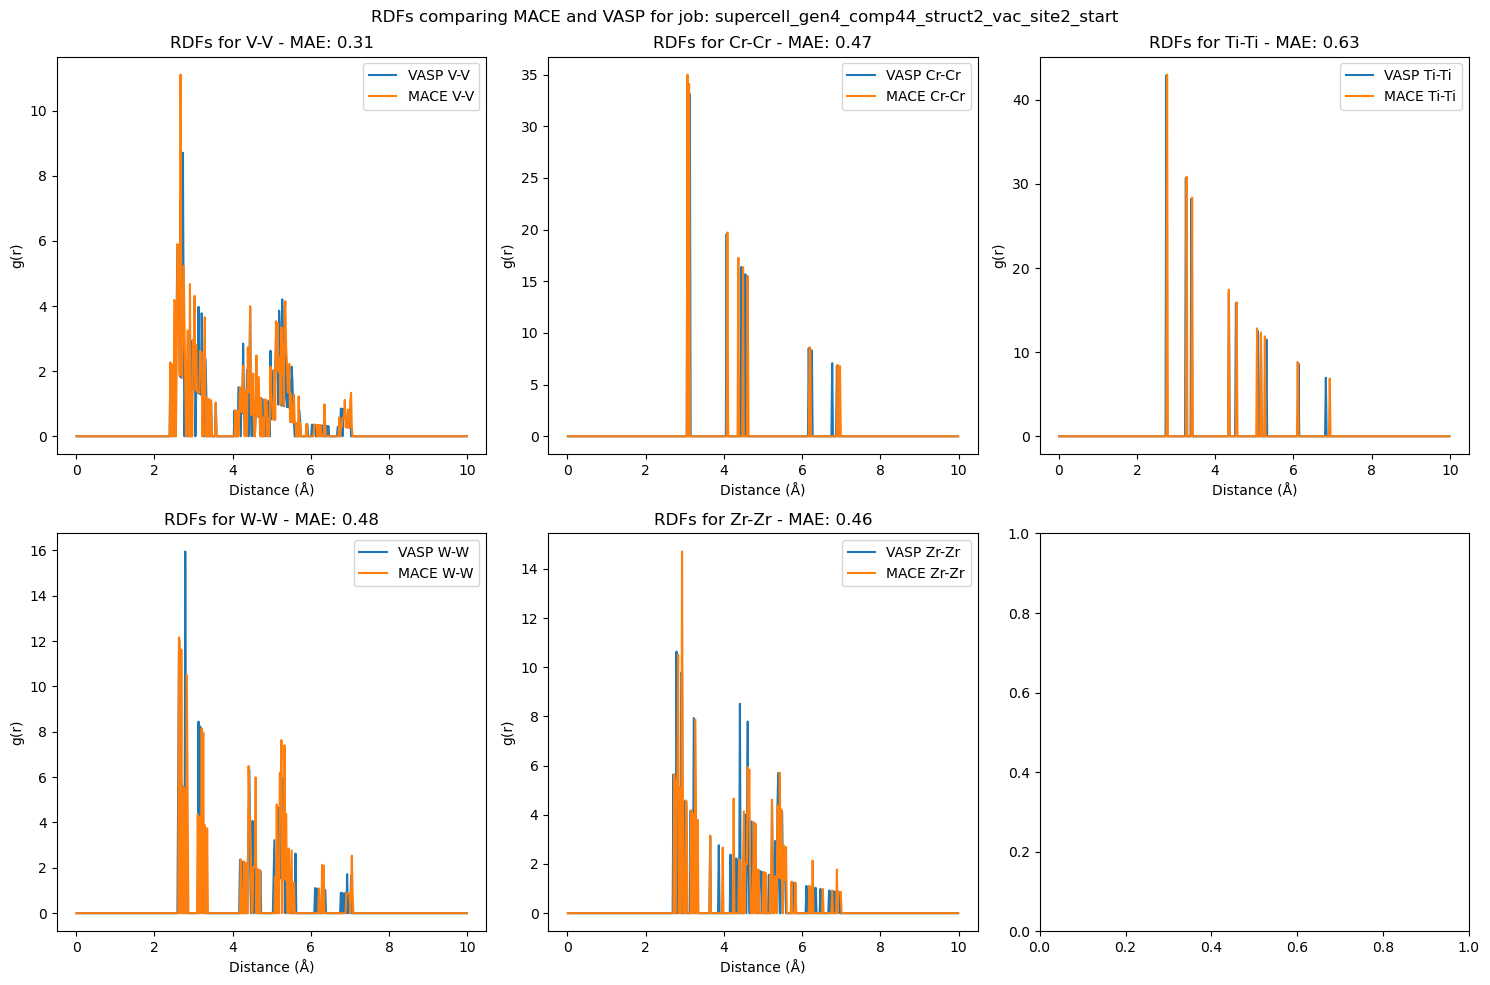

In [21]:
# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
labels = ['V-V', 'Cr-Cr', 'Ti-Ti', 'W-W', 'Zr-Zr']
rdf_pairs = [(vasp_rdf_vv, mace_rdf_vv), (vasp_rdf_crcr, mace_rdf_crcr), (vasp_rdf_titi, mace_rdf_titi), 
             (vasp_rdf_ww, mace_rdf_ww), (vasp_rdf_zrzr, mace_rdf_zrzr)]

# Calculate MAE and plot RDFs for each element pair
for i, (label, (rdf_vasp, rdf_mace)) in enumerate(zip(labels, rdf_pairs)):
    # Determine subplot position
    row = i // 3
    col = i % 3
    
    # Select the subplot
    ax = axs[row, col]
    
    # Calculate Mean Absolute Error
    mae = np.mean(np.abs(rdf_vasp.rdf - rdf_mace.rdf))
    
    # Set the subplot title and labels
    ax.set_title(f"RDFs for {label} - MAE: {mae:.2f}")
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("g(r)")
    
    # Plot VASP and MACE RDFs
    ax.plot(rdf_vasp.r, rdf_vasp.rdf, label=f"VASP {label}")
    ax.plot(rdf_mace.r, rdf_mace.rdf, label=f"MACE {label}")
    
    # Add legend to the subplot
    ax.legend()

# Add a common title to all subplots
fig.suptitle(f"RDFs comparing MACE and VASP for job: {job_name}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()